# 데이터셋 준비

In [3]:
import pandas as pd

wine = pd.read_csv("https://bit.ly/wine_csv_data")
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


### (참고) 데이터 개요를 살펴보기 좋은 유용한 메서드
- `.describe()`
- `.info()`

In [4]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


입력 피쳐, 타겟 피쳐 분리

In [7]:
input_data = wine[['alcohol', 'sugar', 'pH']]
target = wine['class']

In [8]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    input_data, target, test_size=0.2, random_state=42
)

print(train_input.shape)
print(test_input.shape)

(5197, 3)
(1300, 3)


---
# 데이터 전처리 & 로지스틱 회귀 모델
- 이후에 나올 결정 트리에서는 데이터 전처리가 필요 없음(결정 트리 모델의 장점 중 하나임).

In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


👉 사실 로지스틱 회귀 모델 등 여러 머신러닝 모델은 왜 그런 동작을 했는지 설명하기 어려움

- 로지스틱 회귀 모델은 각 피쳐의 계수값을 학습하고, 방정식을 풀어내는 모델인데, 각 계수값이 왜 그렇게 나왔는지 설명하기가 어려움
- 결정 트리는 이유를 설명하기 쉽고, 직관적이라는 점에서 장점이 있음

---
# 결정 트리

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(train_scaled, train_target) # 사실 결정 트리는 스케일링된 값을 굳이 쓰지 않아도 됨
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.996921300750433
0.8561538461538462


---
## 어떤 트리를 그려가며 학습했는지 직접 살펴보기

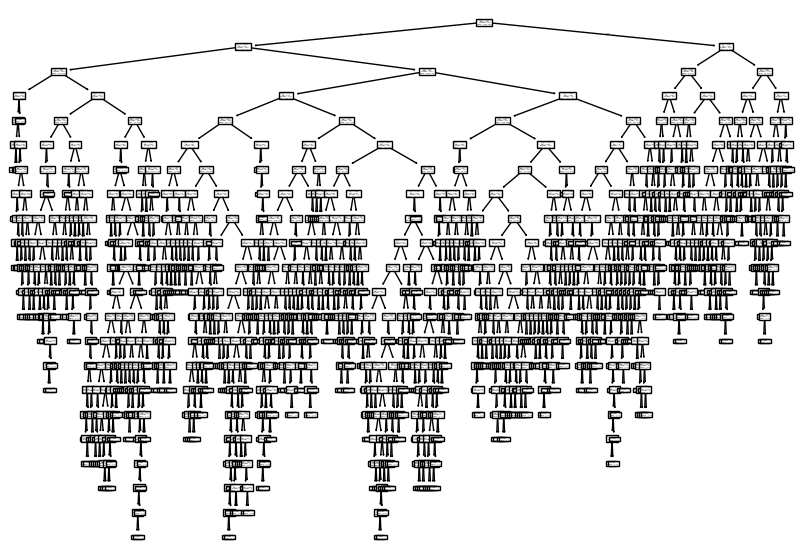

In [12]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 7))
plot_tree(dt)
plt.show()

##### 더 간단히 그려보기
`plot_tree`클래스의 옵션값을 조절해서 트리를 심플하게 볼 수 있다.
- `max_depth`값을 1로 설정해서, 루트 노드로부터 깊이를 1까지만 보도록 하자.
- `filled`값을 True로 해서, 각 노드가 어떤 특성으로 나뉘는지 볼 수 있도록 만들자.

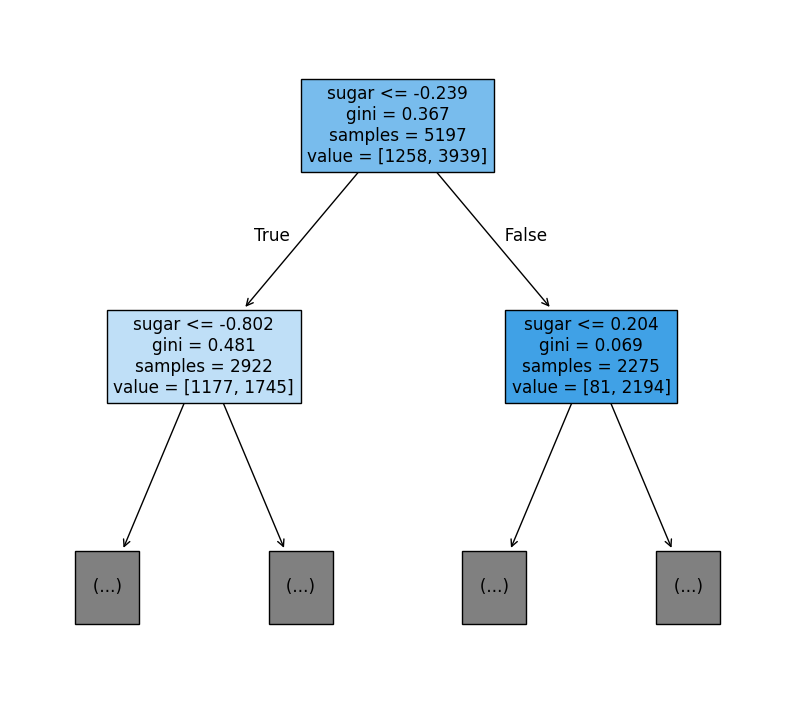

In [13]:
plt.figure(figsize=(10, 9))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

👉 트리 보는 법

- (루트 노드) 전체 데이터 샘플은 5197개이고, 음성 샘플이 1258개, 양성 샘플이 3939개라는 뜻
- (왼쪽 자식 노드) $sugar>-0.239$인 샘플의 수는 2922개이고, 이중에서 음성 샘플은 1177개, 음성 샘플은 1745개라는 뜻
- (오른쪽 자식 노드) $sugar<=-0.239$인 샘플 수는 2275개이고, 이중에서 음성 샘플은 81개, 양성 샘플은 2194개라는 뜻
    - 특정한 색으로 진하게 표시될수록 양성 샘플과 음성 샘플에 대해, 둘 중 특정 샘플의 수가 많다는것(즉 불순도가 낮다는 것)
        - e.g. 오른쪽 자식 노드는 양성 샘플의 개수가 더 많음
        - 이것의 의미는 해당 자식 노드의 부모 노드의 조건식이 특정한 클래스를 잘 구분했다는것을 의미함

👉 지니 불순도(`gini`): 
- 이진 분류일 경우: $\
1 \;-\;\bigl(p_{\text{neg}}^2 \;+\; p_{\text{pos}}^2\bigr)
\ $
    - e.g. 현재 양성 클래스의 비율: $\frac{1258}{5197}$, 음성 클래스의 비율: $\frac{3939}{5197}$ → $gini = 1 - \left(\left(\frac{1258}{5197}\right)^2 + \left(\frac{3939}{5197}\right)^2\right)$
- 다중 분류일 경우: $\text{Gini} \;=\; 1 - \sum_{i=1}^{K} p_i^2$
- `DecisionTreeClassifier`클래스의 `criterion`옵션의 기본 값은 gini이고, 다른 기준(e.g. 엔트로피 불순도 등)도 사용할 수 있다.
- 지니 불순도를 criterion으로 설정한 결정 트리 모델에 대해, 모델의 목표는 노드가 깊어질수록 불순도값을 작게 만드는것이 목표이다. (반대로 값이 높아야 좋은 criterion도 있음)
    - 특정 부모 노드와 자식 노드간의 불순도 차이를 정보 이득(infomation gain)이라고 한다.

즉, 노드에 하나의 클래스만 있다면 지니 불순도는 0이 된다(이런 노드를 순수 노드라고 함). 또한 (이진 분류를 기준으로)지니 불순도가 0.5일 경우가 가장 최악의 경우이다.

👉 가지치기

결정 트리 모델의 깊이를 무한정으로 가져가면 훈련 셋에 오버피팅된다. 따라서 적당한 가지치기가 필요함.

- 가장 간단한 방법은 `max_depth`값을 제한시키는 것(e.g. `max_depth=3`)
- 깊이를 3으로 해서 점수를 다시 출력해보자.

In [14]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)

dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


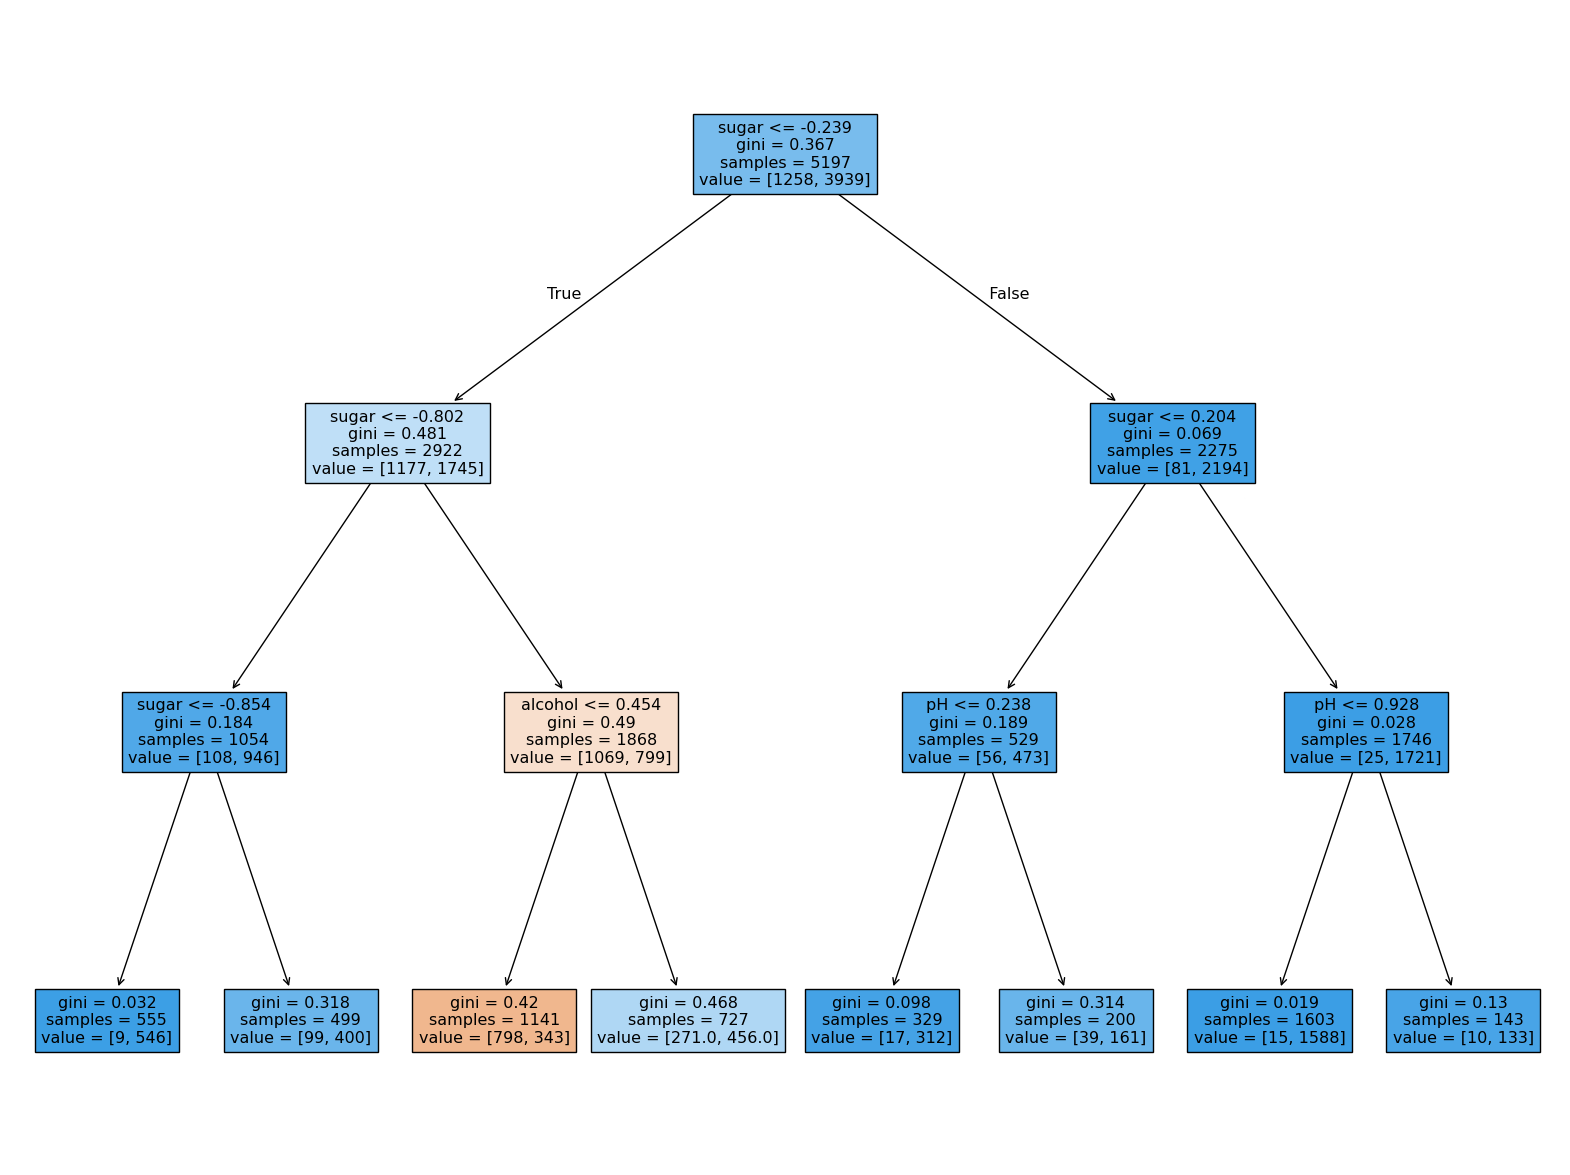

In [15]:
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

👉 `.feature_importances_` 속성을 통해 어떤 피쳐를 중요한 피쳐로써 활용했는지 확인할 수 있다.

In [ ]:
print(dt.feature_importances_) # 각각 알콜, 당도, pH

[0.12345626 0.86862934 0.0079144 ]
